# **SETransformer: Predicción del tiempo de vida restante (RUL) con Transformer para el Mantenimiento Predictivo en C-MAPSS dataset.**

El SETransformer es un modelo basado en la arquitectura Transformer diseñado para predecir el tiempo de vida útil restante (RUL) en motores de turbina usando el dataset C-MAPSS de la NASA. Aprovechando mecanismos de atención, el modelo captura dependencias temporales complejas en secuencias multivariadas de sensores, superando limitaciones de enfoques tradicionales como LSTMs. Con técnicas como ventanas deslizantes y validación cruzada, SETransformer logra mayor precisión y robustez, demostrando su potencial para mantenimiento predictivo en entornos industriales donde la anticipación de fallos es crítica.

## **Desarrollo.**

### **Librerías.**

In [1]:
%matplotlib inline

#Librerias importadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from itertools import product
import warnings
import optuna
import time
import sys
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# Configuración de la semilla para reproducibilidad
# Esta función establece la semilla para la reproducibilidad en experimentos de aprendizaje automático.
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Si usas GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)  # Para reproducibilidad en hash de Python
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Para reproducibilidad en TensorFlow (si es necesario)
    SEED = 42


#import warnings
#warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors") # solo si se desea ignorar el waaning de la máscara


optuna.logging.set_verbosity(optuna.logging.DEBUG) ##activar el logging de optuna para ver los mensajes de depuración

torch.use_deterministic_algorithms(True) # Para forzar el uso de algoritmos deterministas, es un modo determinista de pytorch, pero puede ser más lento. Si se establece warn_only en True, se generarán advertencias si se utilizan algoritmos no deterministas y sigue ejecutando.
# CONFIG
SEED = 42
set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Los resultados pueden variar ligeramente entre dispositivos incluso con semillas fijas, yo trabaje con cpu.
print(device)

cpu


### **Funciones.**

In [2]:
# Cargar todos los conjuntos de prueba y RUL reales
def load_and_concatenate_test_sets():
    dfs_test, dfs_rul = [], []
    for i in range(1, 5):
        url_test = f'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00{i}.txt'
        url_rul = f'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00{i}.txt'

        df_test = pd.read_csv(url_test, sep=' ', header=None)
        df_test.dropna(axis=1, inplace=True)
        index_names = ['unit_nr', 'time_cycles']
        setting_names = ['altitude', 'mach', 'temperature']
        sensor_names = ["t2", "t24", "t30", "t50", "p2", "p15", "p30",
            "nf", "nc", "epr", "ps30", "phi", "nrf", "nrc", "bpr", "farb",
            "htbleed", "nf_dmd", "pcnfr_dmd", "w31", "w32"]
        col_names = index_names + setting_names + sensor_names
        df_test.columns=col_names
        df_rul = pd.read_csv(url_rul, header=None)
        df_rul.columns = ['RUL']

        df_test[['htbleed', 'nf_dmd']] = df_test[['htbleed', 'nf_dmd']].astype(float)
        dfs_test.append(df_test)
        dfs_rul.append(df_rul)
    return pd.concat(dfs_test, axis=0, ignore_index=True) , pd.concat(dfs_rul, axis=0, ignore_index=True)

In [3]:
# 1. Cargar y concatenar datasets
def load_and_concatenate_cmaps():
    datasets = []
    for i in range(1, 5):
        url_train = f'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00{i}.txt'
        df = pd.read_csv(url_train, sep=' ', header=None)
        df.dropna(axis=1, inplace=True)
        index_names = ['unit_nr', 'time_cycles']
        setting_names = ['altitude', 'mach', 'temperature']
        sensor_names = ["t2", "t24", "t30", "t50", "p2", "p15", "p30","nf", "nc", "epr", "ps30", "phi", "nrf", "nrc", "bpr", "farb",
            "htbleed", "nf_dmd", "pcnfr_dmd", "w31", "w32"]
        col_names = index_names + setting_names + sensor_names
        df.columns=col_names
        df[['htbleed', 'nf_dmd']] = df[['htbleed', 'nf_dmd']].astype(float)
        datasets.append(df)
    return pd.concat(datasets, axis=0, ignore_index=True)

In [4]:
#SEGMENTO DONDE DEFINO FUNCIONES A UTILIZAR

# Esta función evalúa el desempeño de un modelo de regresión
def evaluate(y_true, y_hat, label='test'):
    """
    Evalúa el desempeño de un modelo de regresión utilizando RMSE y R².

    Parámetros:
    y_true -- valores reales de la variable dependiente (array o lista)
    y_hat -- valores predichos por el modelo (array o lista)
    label -- etiqueta opcional para identificar el conjunto evaluado (por defecto: 'test')
    """

    # Calcula el Error Cuadrático Medio (MSE)
    mse = mean_squared_error(y_true, y_hat)
    # Calcula la Raíz del MSE (RMSE), que indica el error promedio en las mismas unidades que la variable dependiente
    rmse = np.sqrt(mse)
    # Calcula el Coeficiente de Determinación (R²), que mide la proporción de varianza explicada por el modelo
    variance = r2_score(y_true, y_hat)

    # Imprime los resultados de evaluación con una etiqueta
    print(f'{label} set RMSE: {rmse:.4f}, R²: {variance:.4f}')

def add_remaining_useful_life(df):
    """
    Añade la columna RUL (Remaining Useful Life) al dataframe C-MAPSS.

    Parámetros:
    df -- DataFrame con datos de los sensores, que debe incluir las columnas 'unit_nr' y 'time_cycles'

    Retorna:
    Un nuevo DataFrame con una columna adicional llamada 'RUL'
    """

    # Paso 1: Calcular el número máximo de ciclos por cada unidad (motor)
    # Esto representa el ciclo en el que la unidad falló (fin de su vida útil)
    max_cycles_per_unit = df.groupby("unit_nr")["time_cycles"].transform('max')

    # Paso 2: Calcular el Remaining Useful Life restando el ciclo actual al máximo ciclo
    df["RUL"] = max_cycles_per_unit - df["time_cycles"]

    # Retornar el DataFrame modificado con la columna RUL añadida
    return df

In [5]:
def time_series_smoothing(
    df: pd.DataFrame,
    group_columns: list = ["unit_nr"],
    feature_columns: list = None,
    alpha: float = 0.4
) -> pd.DataFrame:
    """
    Aplica suavizado exponencial a series temporales agrupadas y elimina muestras iniciales.

    Parámetros:
        df: DataFrame de entrada.
        group_columns: Columnas para agrupar (ej: ["unit_nr", "flight_id"]).
        feature_columns: Columnas a suavizar.
        alpha: Factor de suavizado (0 < alpha <= 1).
        n_samples: Muestras iniciales a eliminar por grupo.

    Retorna:
        DataFrame procesado.
    """
    df = df.copy()
    
    # 1. Suavizado Exponencial
    smoothed = (
        df.groupby(group_columns, sort=False)[feature_columns]
        .apply(lambda x: x.ewm(alpha=alpha).mean())
        .reset_index(level=0, drop=True)  # Alinear índices
    )
    
    df[feature_columns] = smoothed
    
    return df

In [6]:
def create_sequences_with_condition(df, window_size, feature_cols, target_col, condition_col="operating_condition_id"):
    sequences = []
    targets = []
    op_ids = []
    grouped = df.groupby("unit_nr")

    for _, group in grouped:
        for i in range(len(group) - window_size):
            seq = group.iloc[i:i+window_size]
            sequences.append(seq[feature_cols].values)
            targets.append(group.iloc[i+window_size][target_col])
            op_ids.append(seq[condition_col].values[-1])  

    return np.array(sequences), np.array(targets), np.array(op_ids)


In [7]:
def create_sequences_with_condition2(df, window_size, feature_cols, target_col, condition_col="operating_condition_id"):
    sequences = []
    targets = []
    op_ids = []

    for unit in df['unit_nr'].unique():
        unit_df = df[df['unit_nr'] == unit]
        for i in range(len(unit_df) - window_size):
            seq = unit_df.iloc[i:i+window_size]
            label = unit_df.iloc[i+window_size][target_col]

            sequences.append(seq[feature_cols].values)
            targets.append(label)

            # Tomar la secuencia completa de operating IDs (para usar embedding por paso de tiempo)
            op_ids.append(seq[condition_col].astype(int).values)

    return np.array(sequences), np.array(targets), np.array(op_ids, dtype=np.int64)

In [8]:
def create_sequences(df, window_size, feature_cols, target_col):
    sequences = []
    targets = []
    for unit in df['unit_nr'].unique():
        unit_df = df[df['unit_nr'] == unit]
        for i in range(len(unit_df) - window_size):
            seq = unit_df.iloc[i:i+window_size][feature_cols].values
            label = unit_df.iloc[i+window_size][target_col]
            sequences.append(seq)
            targets.append(label)
    return np.array(sequences), np.array(targets)

In [107]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def compute_metrics2(y_true, y_pred, cap=125):
    """
    Calcula RMSE, MAE y R² entre valores verdaderos y predichos,
    aplicando un límite superior opcional (por defecto 125).

    Args:
        y_true (array-like): Valores reales.
        y_pred (array-like): Valores predichos por el modelo.
        cap (float): Valor máximo permitido para los valores verdaderos.

    Returns:
        dict: Diccionario con métricas {'rmse': ..., 'mae': ..., 'r2': ...}
    """
    y_true_capped = np.clip(y_true, None, cap)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true_capped, y_pred))
    mae = mean_absolute_error(y_true_capped, y_pred)
    r2 = r2_score(y_true_capped, y_pred)

    return {'rmse': rmse, 'mae': mae, 'r2': r2}

In [9]:
def compute_metrics(y_true, y_pred, cap=125):
    """
    Calcula RMSE y R² entre los valores verdaderos y predichos,
    aplicando un límite superior opcional (por defecto 125).
    
    Args:
        y_true (array-like): Valores reales.
        y_pred (array-like): Valores predichos por el modelo.
        cap (float): Valor máximo permitido para los valores verdaderos.

    Returns:
        dict: Diccionario con métricas {'rmse': ..., 'r2': ...}
    """
    y_true_capped = np.clip(y_true, None, cap)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true_capped, y_pred))
    r2 = r2_score(y_true_capped, y_pred)

    return {'rmse': rmse, 'r2': r2}


In [10]:
def scaling_by_condition(df_train, df_test, feature_columns, condition_column='operating_condition_id'):
    """
    Estandariza características por condición operativa, guardando los parámetros de escalamiento
    
    Args:
        df_train (pd.DataFrame): DataFrame de entrenamiento
        df_test (pd.DataFrame): DataFrame de prueba
        feature_columns (list): Lista de columnas a escalar
        condition_column (str): Columna que define las condiciones operativas
        
    Returns:
        tuple: (df_train_scaled, df_test_scaled, scalers_dict) 
               donde scalers_dict contiene los escaladores por condición
    """
    scalers_dict = {}
    
    # Crear copias para no modificar los DataFrames originales
    train_scaled = df_train.copy()
    test_scaled = df_test.copy()
    
    for condition in df_train[condition_column].unique():
        # Crear y ajustar scaler solo con datos de entrenamiento
        scaler = StandardScaler()
        scaler.fit(df_train.loc[df_train[condition_column]==condition, feature_columns])
        
        # Guardar scaler para uso futuro
        scalers_dict[condition] = scaler
        
        train_scaled[feature_columns] = train_scaled[feature_columns].astype('float64')
        test_scaled[feature_columns] = test_scaled[feature_columns].astype('float64')
        
        # Transformar datos de entrenamiento y prueba
        train_scaled.loc[df_train[condition_column]==condition, feature_columns] = scaler.transform(
            df_train.loc[df_train[condition_column]==condition, feature_columns])
        
        # Solo transformar datos de prueba si la condición existe en test
        if condition in df_test[condition_column].unique():
            test_scaled.loc[df_test[condition_column]==condition, feature_columns] = scaler.transform(
                df_test.loc[df_test[condition_column]==condition, feature_columns])
    
    return train_scaled, test_scaled

In [11]:
def fix_unit_nr_continuity(df, unit_col='unit_nr'):
    """
    Corrige la continuidad de la columna de unidades 'unit_nr' en un DataFrame concatenado
    donde los unit_nr se reinician después de cada dataset.

    Parámetros:
    - df: DataFrame de entrada.
    - unit_col: nombre de la columna que contiene el identificador de unidades (por defecto 'unit_nr').

    Retorna:
    - DataFrame con una nueva columna 'unit_nr_fixed' que tiene la secuencia continua corregida.
    """
    # Detectar los puntos donde unit_nr se reinicia
    unit_changes = df[unit_col].diff() < 0

    # Crear un grupo incremental donde haya cambios
    group = unit_changes.cumsum()

    # Corregir unit_nr sumando un offset basado en el número de resets detectados
    df['unit_nr_fixed'] = df[unit_col] + (group * df[unit_col].max())

    # Mapear a una secuencia ordenada 1, 2, 3, 4, ...
    unit_mapping = {old: new for new, old in enumerate(df['unit_nr_fixed'].unique(), start=1)}
    df['unit_nr_fixed'] = df['unit_nr_fixed'].map(unit_mapping)
    df = df.drop(columns=['unit_nr']).rename(columns={'unit_nr_fixed': 'unit_nr'})

    return df

In [12]:
# Antes de comenzar a trazar, implementemos la escala específica de la condición.
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['altitude'] = df_op_cond['altitude'].round()
    df_op_cond['mach'] = df_op_cond['mach'].round(decimals=2)
    
    # convertir las configuraciones a cadena y concatenarlas convierte la condición operativa en una variable categórica
    df_op_cond['operating_condition_id'] = df_op_cond['altitude'].astype(str) + '_' + \
                        df_op_cond['mach'].astype(str) + '_' + \
                        df_op_cond['temperature'].astype(str)
    
    return df_op_cond

### **Carga y Procesamiento de Datos.**

In [13]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['altitude', 'mach', 'temperature']
sensor_cols = ["t2", "t24", "t30", "t50", "p2", "p15", "p30","nf", 
               "nc", "epr", "ps30", "phi", "nrf", "nrc", "bpr", "farb",
                "htbleed", "nf_dmd", "pcnfr_dmd", "w31", "w32"]

# Parámetros globales
WINDOW_SIZE = 30
BATCH_SIZE = 64
EPOCHS = 30
LR = 0.001

In [14]:
# 1. CARGA DE DATOS
df_train = load_and_concatenate_cmaps()
df_test, y_true = load_and_concatenate_test_sets()
df_train = fix_unit_nr_continuity(df_train, unit_col='unit_nr')
df_test = fix_unit_nr_continuity(df_test, unit_col='unit_nr')

In [15]:
# Obtener la columna y quitarla del DataFrame
col = df_train.pop('unit_nr')
# Insertarla al inicio (posición 0)
df_train.insert(0, 'unit_nr', col)

In [16]:
# Obtener la columna y quitarla del DataFrame
col = df_test.pop('unit_nr')
# Insertarla al inicio (posición 0)
df_test.insert(0, 'unit_nr', col)

In [17]:
#añadimos el RUL
df_train = add_remaining_useful_life(df_train)

In [18]:
X_train = df_train[setting_names + sensor_cols].copy()
y_train = df_train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

In [19]:
X_train_condition = add_operating_condition(df_train)
X_test_condition = add_operating_condition(df_test)
X_train_condition_scaled, X_test_condition_scaled = scaling_by_condition(X_train_condition, X_test_condition, sensor_cols)
X_train_condition_smooth = time_series_smoothing(X_train_condition_scaled, group_columns=['unit_nr'], feature_columns=sensor_cols, alpha=0.2)
X_test_condition_smooth = time_series_smoothing(X_test_condition_scaled, group_columns=['unit_nr'], feature_columns=sensor_cols, alpha=0.2)
X_train_encoded = X_train_condition_smooth.drop(columns=setting_names, axis=1)
X_test_encoded = X_test_condition_smooth.drop(columns=setting_names, axis=1)

In [20]:
X_train_encoded['operating_condition_id'].unique()

array(['-0.0_-0.0_100.0', '0.0_-0.0_100.0', '-0.0_0.0_100.0',
       '0.0_0.0_100.0', '35.0_0.84_100.0', '42.0_0.84_100.0',
       '25.0_0.62_60.0', '20.0_0.7_100.0', '10.0_0.25_100.0'],
      dtype=object)

In [21]:
X_test_encoded['operating_condition_id'].unique()

array(['0.0_0.0_100.0', '-0.0_-0.0_100.0', '-0.0_0.0_100.0',
       '0.0_-0.0_100.0', '10.0_0.25_100.0', '20.0_0.7_100.0',
       '35.0_0.84_100.0', '42.0_0.84_100.0', '25.0_0.62_60.0'],
      dtype=object)

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_train_encoded['operating_condition_id'] = le.fit_transform(X_train_encoded['operating_condition_id'])
X_test_encoded['operating_condition_id'] = le.transform(X_test_encoded['operating_condition_id'])

In [23]:
X_train_encoded['operating_condition_id'].unique()

array([0, 2, 1, 3, 7, 8, 6, 5, 4])

In [24]:
X_test_encoded['operating_condition_id'].unique()

array([3, 0, 1, 2, 4, 5, 7, 8, 6])

In [25]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   unit_nr                 160359 non-null  int64  
 1   time_cycles             160359 non-null  int64  
 2   t2                      160359 non-null  float64
 3   t24                     160359 non-null  float64
 4   t30                     160359 non-null  float64
 5   t50                     160359 non-null  float64
 6   p2                      160359 non-null  float64
 7   p15                     160359 non-null  float64
 8   p30                     160359 non-null  float64
 9   nf                      160359 non-null  float64
 10  nc                      160359 non-null  float64
 11  epr                     160359 non-null  float64
 12  ps30                    160359 non-null  float64
 13  phi                     160359 non-null  float64
 14  nrf                 

In [26]:
# Selección de características
feature_cols = sensor_cols 	

target_col = 'RUL'

In [27]:
X_train_encoded['RUL'] = y_train_clipped.astype('float32')
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   unit_nr                 160359 non-null  int64  
 1   time_cycles             160359 non-null  int64  
 2   t2                      160359 non-null  float64
 3   t24                     160359 non-null  float64
 4   t30                     160359 non-null  float64
 5   t50                     160359 non-null  float64
 6   p2                      160359 non-null  float64
 7   p15                     160359 non-null  float64
 8   p30                     160359 non-null  float64
 9   nf                      160359 non-null  float64
 10  nc                      160359 non-null  float64
 11  epr                     160359 non-null  float64
 12  ps30                    160359 non-null  float64
 13  phi                     160359 non-null  float64
 14  nrf                 

In [28]:
#X_train_encoded=X_train_encoded.astype('float32') # Convertir a float32 para evitar problemas de memoria
X_train_encoded.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   unit_nr                 160359 non-null  int64  
 1   time_cycles             160359 non-null  int64  
 2   t2                      160359 non-null  float64
 3   t24                     160359 non-null  float64
 4   t30                     160359 non-null  float64
 5   t50                     160359 non-null  float64
 6   p2                      160359 non-null  float64
 7   p15                     160359 non-null  float64
 8   p30                     160359 non-null  float64
 9   nf                      160359 non-null  float64
 10  nc                      160359 non-null  float64
 11  epr                     160359 non-null  float64
 12  ps30                    160359 non-null  float64
 13  phi                     160359 non-null  float64
 14  nrf                 

In [29]:
#X_test_encoded=X_test_encoded.astype('float32') # Convertir a float32 para evitar problemas de memoria
X_test_encoded.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104897 entries, 0 to 104896
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   unit_nr                 104897 non-null  int64  
 1   time_cycles             104897 non-null  int64  
 2   t2                      104897 non-null  float64
 3   t24                     104897 non-null  float64
 4   t30                     104897 non-null  float64
 5   t50                     104897 non-null  float64
 6   p2                      104897 non-null  float64
 7   p15                     104897 non-null  float64
 8   p30                     104897 non-null  float64
 9   nf                      104897 non-null  float64
 10  nc                      104897 non-null  float64
 11  epr                     104897 non-null  float64
 12  ps30                    104897 non-null  float64
 13  phi                     104897 non-null  float64
 14  nrf                 

### **Secuencias.**

Este código prepara los datos para entrenar un modelo de aprendizaje automático utilizando ventanas deslizantes (sliding windows). Primero, se crean secuencias de entrenamiento (X e y) a partir de los datos preprocesados usando una ventana de tamaño fija, donde X contiene las características y y los valores objetivo, convirtiéndolos luego en tensores de PyTorch. Luego, se define un Dataset personalizado (CMAPSSDataset) para manejar estos tensores, implementando los métodos __len__ y __getitem__ para acceder a los datos. Posteriormente, los datos se dividen en conjuntos de entrenamiento (80%) y validación (20%)  y se crean DataLoader para cada conjunto, lo que permite cargar los datos por lotes (BATCH_SIZE) durante el entrenamiento y la validación del modelo.

In [30]:
X, y, op_ids = create_sequences_with_condition(X_train_encoded, WINDOW_SIZE, sensor_cols, target_col)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
op_ids = torch.tensor(op_ids, dtype=torch.long)

In [31]:
# Dataset personalizado 
class CMAPSSDataset(Dataset):
    def __init__(self, X, y, op_ids):
        self.X = X
        self.y = y
        self.op_ids = op_ids
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.op_ids[idx]

# Divide en entrenamiento y validación (80% / 20%)
# División en entrenamiento/validación
X_train, X_val, y_train, y_val, op_train, op_val = train_test_split(
    X, y, op_ids, test_size=0.2, random_state=SEED
)

train_dataset = CMAPSSDataset(X_train, y_train, op_train)
val_dataset = CMAPSSDataset(X_val, y_val, op_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

### **Arquitectura del Transformer.**

El código implementa un modelo Transformer para predecir el RUL (Remaining Useful Life) como un problema de regresión. Primero, la clase PositionalEncoding añade información posicional a los datos de entrada mediante funciones sinusoidales, lo que permite al modelo considerar el orden temporal de las secuencias. Luego, la clase principal TransformerRUL procesa los datos en 4 etapas: (1) una capa de embedding lineal proyecta las características de entrada a un espacio de dimensión d_model; (2) el codificador posicional añade información temporal; (3) varias capas de Transformer (definidas por num_layers) procesan la secuencia capturando dependencias temporales complejas mediante mecanismos de auto-atención; y finalmente (4) una red fully-connected reduce la representación del último paso temporal a una predicción escalar de RUL. 

Este enfoque es particularmente adecuado para datos secuenciales de sensores, ya que el Transformer puede modelar relaciones temporales de largo alcance y patrones complejos en los datos, superando limitaciones de arquitecturas tradicionales como LSTMs en ciertos escenarios. La salida final es un valor continuo que representa el tiempo restante estimado hasta la falla del equipo.

In [32]:
class SensorAttention(nn.Module):
    def __init__(self, feature_dim, reduction=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // reduction),
            nn.ReLU(),
            nn.Linear(feature_dim // reduction, feature_dim),
            nn.Sigmoid()
        )
        self.att_weights = None  # atributo para almacenar los pesos

    def forward(self, x):
        # x: (batch, seq_len, feature_dim)
        x_permuted = x.permute(0, 2, 1)                    # (batch, feature_dim, seq_len)
        squeeze = self.avg_pool(x_permuted).squeeze(-1)   # (batch, feature_dim)
        weights = self.fc(squeeze).unsqueeze(1)           # (batch, 1, feature_dim)
        self.att_weights = weights.detach().cpu()         # guarda los pesos (sin gradiente)
        return x * weights                                # broadcasting (batch, seq_len, feature_dim)

In [33]:
# Transformer para regresión RUL
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerRUL(nn.Module):
    def __init__(self, feature_dim, num_op_conditions, d_model=64, nhead=4, num_layers=2, dim_feedforward=128):
        super().__init__()
        self.sensor_attention = SensorAttention(feature_dim)
        self.embedding = nn.Linear(feature_dim, d_model)
        self.op_embedding = nn.Embedding(num_op_conditions, d_model)  # NUEVO
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x, op_id):
        x = self.sensor_attention(x)           # atención por sensor (por muestra)
        x = self.embedding(x)                  # proyección a espacio d_model
        op_embed = self.op_embedding(op_id).unsqueeze(1)  # (batch, 1, d_model)
        x = x + op_embed  # broadcast sobre la secuencia
        x = self.pos_encoder(x)                # codificación posicional
        x = self.transformer_encoder(x)        # encoder temporal
        x = x[:, -1, :]                        # último paso temporal
        return self.fc(x).squeeze()            # regresión final
# último token: El objetivo real del mantenimiento predictivo es saber cuánto le queda de vida al sistema hoy, no en cada instante pasado. 
# Por eso, durante la inferencia/test, se toma la última fila de cada unidad.

### **Entrenamiento.**

Este código implementa el proceso de entrenamiento y validación de un modelo Transformer para predecir el RUL (Remaining Useful Life) utilizando PyTorch. El ciclo de entrenamiento itera durante un número definido de épocas (EPOCHS), donde en cada iteración: (1) el modelo procesa los lotes de secuencias de datos de entrenamiento (seqs) para generar predicciones (outputs), (2) calcula el error cuadrático medio (MSE) entre las predicciones y los valores reales (targets), (3) actualiza los parámetros del modelo mediante backpropagation con el optimizador Adam. Paralelamente, en la fase de validación, el modelo evalúa su rendimiento sobre datos no vistos (validation set) sin actualizar sus pesos, registrando tanto las pérdidas de entrenamiento como de validación para monitorizar el aprendizaje y evitar overfitting. Las pérdidas promedio por lote se almacenan en train_losses y val_losses para su posterior análisis, mostrando en cada época los valores de pérdida que indican el rendimiento del modelo en ambas fases. 

In [34]:
# Entrenamiento
set_seed(SEED)
model = TransformerRUL(X.shape[2], num_op_conditions=len(X_train_encoded["operating_condition_id"].unique())).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for seqs, targets, op_ids in train_loader:
        seqs, targets, op_ids = seqs.to(device), targets.to(device), op_ids.to(device)

        optimizer.zero_grad()
        outputs = model(seqs, op_ids)  # <- PASA EL operating_condition_id
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # VALIDACIÓN
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for seqs, targets, op_ids in val_loader:
            seqs, targets, op_ids = seqs.to(device), targets.to(device), op_ids.to(device)
            outputs = model(seqs, op_ids)  # <- PASA EL operating_condition_id
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/30, Train Loss: 616.1085, Val Loss: 194.6655
Epoch 2/30, Train Loss: 180.5907, Val Loss: 171.8420
Epoch 3/30, Train Loss: 168.5736, Val Loss: 162.6939
Epoch 4/30, Train Loss: 164.2679, Val Loss: 158.3318
Epoch 5/30, Train Loss: 161.3566, Val Loss: 155.0613
Epoch 6/30, Train Loss: 158.5409, Val Loss: 152.9730
Epoch 7/30, Train Loss: 156.7869, Val Loss: 152.9139
Epoch 8/30, Train Loss: 155.2440, Val Loss: 151.4614
Epoch 9/30, Train Loss: 153.6680, Val Loss: 149.3814
Epoch 10/30, Train Loss: 152.0449, Val Loss: 149.9226
Epoch 11/30, Train Loss: 151.9948, Val Loss: 149.8992
Epoch 12/30, Train Loss: 150.1451, Val Loss: 148.9996
Epoch 13/30, Train Loss: 149.1977, Val Loss: 146.3449
Epoch 14/30, Train Loss: 147.9402, Val Loss: 144.2738
Epoch 15/30, Train Loss: 147.0367, Val Loss: 146.3002
Epoch 16/30, Train Loss: 146.1235, Val Loss: 144.0014
Epoch 17/30, Train Loss: 145.3858, Val Loss: 143.8260
Epoch 18/30, Train Loss: 143.7642, Val Loss: 141.8429
Epoch 19/30, Train Loss: 142.7153, Va

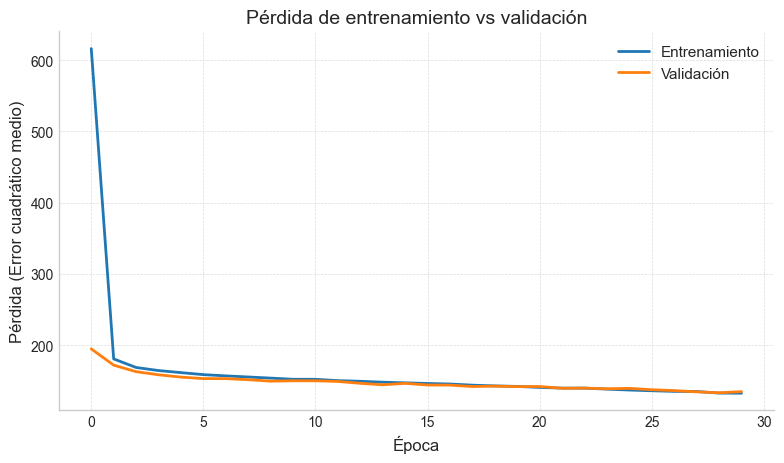

In [35]:
# Estilo limpio y legible
plt.style.use("seaborn-v0_8-whitegrid")  

fig, ax = plt.subplots(figsize=(8, 4.8))  # buena relación de aspecto 5:3

ax.plot(train_losses, label="Entrenamiento", color="#1f77b4", linewidth=2)
ax.plot(val_losses, label="Validación", color="#ff7f0e", linewidth=2)

# Etiquetas claras y específicas
ax.set_xlabel("Época", fontsize=12)
ax.set_ylabel("Pérdida (Error cuadrático medio)", fontsize=12)
ax.set_title("Pérdida de entrenamiento vs validación", fontsize=14)

# Mejorar legibilidad
ax.legend(frameon=False, fontsize=11)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="both", labelsize=10)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [36]:
#X_test_seq_list = []
#operating_id_list = []

# Para cada unidad en el set de test
#for unit in X_test_encoded['unit_nr'].unique():
#    unit_df = X_test_encoded[X_test_encoded['unit_nr'] == unit].sort_values('time_cycles')
    
    # Secuencia de sensores
#    if len(unit_df) >= WINDOW_SIZE:
#        seq = unit_df.iloc[-WINDOW_SIZE:][sensor_cols].values
#        op_id_seq = unit_df.iloc[-WINDOW_SIZE:]['operating_condition_id'].values
#    else:
#        pad_len = WINDOW_SIZE - len(unit_df)
#        pad_seq = np.zeros((pad_len, len(sensor_cols)))
#        pad_opid = np.full((pad_len,), unit_df['operating_condition_id'].values[0])  # asumimos que el ID se mantiene
#        seq = np.vstack((pad_seq, unit_df[sensor_cols].values))
#        op_id_seq = np.concatenate([pad_opid, unit_df['operating_condition_id'].values])
    
#    X_test_seq_list.append(seq)
#    operating_id_list.append(op_id_seq)

# Convertir a tensores
#X_test_tensor = torch.tensor(np.array(X_test_seq_list), dtype=torch.float32).to(device)  # (N, WINDOW_SIZE, features)
#operating_id_tensor = torch.tensor(np.array(operating_id_list), dtype=torch.long).to(device)  # (N, WINDOW_SIZE)

In [37]:
X_test_list = []
op_id_list = []

# Para cada unidad, extraemos la última secuencia completa de tamaño WINDOW_SIZE
for unit in X_test_encoded['unit_nr'].unique():
    unit_df = X_test_encoded[X_test_encoded['unit_nr'] == unit].sort_values('time_cycles')
    
    if len(unit_df) >= WINDOW_SIZE:
        seq_df = unit_df.iloc[-WINDOW_SIZE:]
    else:
        pad = pd.DataFrame(0, index=range(WINDOW_SIZE - len(unit_df)), columns=unit_df.columns)
        seq_df = pd.concat([pad, unit_df], ignore_index=True).iloc[-WINDOW_SIZE:]

    # Extraer secuencia de sensores
    seq = seq_df[feature_cols].values
    X_test_list.append(seq)

    # Extraer el último operating_condition_id como representación de la secuencia
    op_id = seq_df['operating_condition_id'].values[-1]
    op_id_list.append(op_id)

# Convertir a tensores
X_test = np.array(X_test_list)
op_ids_test = np.array(op_id_list)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
op_test_tensor = torch.tensor(op_ids_test, dtype=torch.long).to(device)


In [38]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor, op_test_tensor)
    attention_weights = model.sensor_attention.att_weights

print(attention_weights.shape)  # Debería ser (batch_size, 1, feature_dim)

torch.Size([707, 1, 21])


### **Resultados.**

In [39]:
# Calcular la métrica de evaluación (RMSE o R²) en el conjunto de validación
metrics = compute_metrics(y_true, predictions)
print(f"RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.2f}")

RMSE: 13.62, R²: 0.90


In [ ]:
# Guardar el estado del modelo.
torch.save(model.state_dict(), 'transformer_model_first_embeddings.pth')#

In [41]:
#model.load_state_dict(torch.load('transformer_model_first.pth',weights_only=True))
#model.eval()  

### **Visualizaciones.**

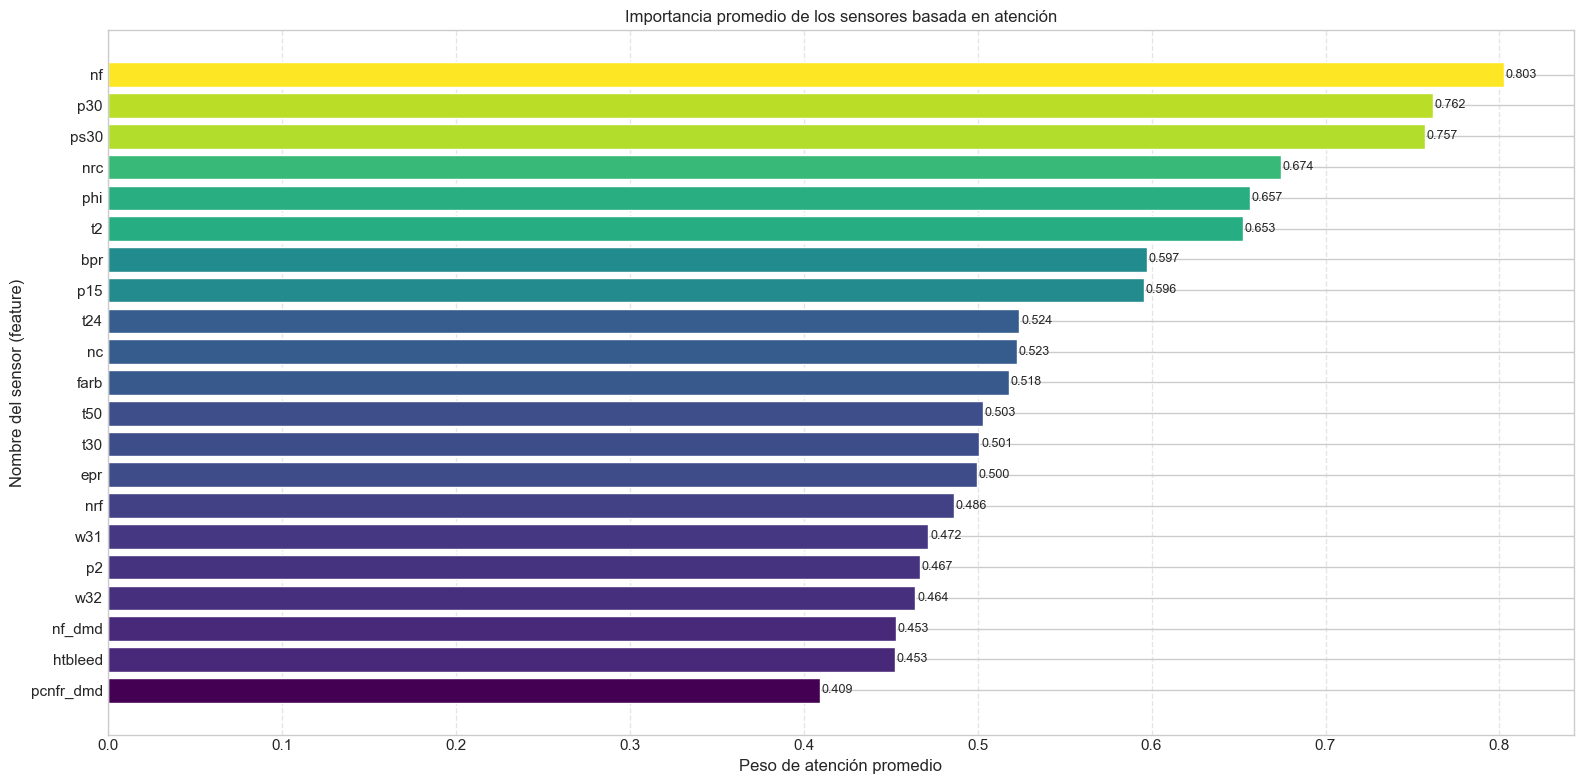

In [74]:
# Convertir y calcular pesos de atención promedio
att_weights_np = attention_weights.squeeze(1).cpu().numpy()  # (batch_size, feature_dim)
mean_weights = att_weights_np.mean(axis=0)

# Crear DataFrame y ordenar
attention_df = pd.DataFrame({
    'feature': feature_cols,
    'attention_weight': mean_weights
}).sort_values(by='attention_weight', ascending=True)

# Normalizar para aplicar viridis
norm = plt.Normalize(attention_df['attention_weight'].min(), attention_df['attention_weight'].max())
colors = plt.cm.viridis(norm(attention_df['attention_weight'].values))

# Gráfico horizontal
plt.figure(figsize=(16, 8))
bars = plt.barh(
    attention_df['feature'],
    attention_df['attention_weight'],
    color=colors
)

# Añadir texto con los valores
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001,             # un poco a la derecha del final de la barra
             bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}",            # formato con 3 decimales
             va='center', ha='left', fontsize=9)

# Personalización
plt.xlabel("Peso de atención promedio")
plt.ylabel("Nombre del sensor (feature)")
plt.title("Importancia promedio de los sensores basada en atención")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [43]:
# plot predictions
def plot_rul_predictions(y_true, y_pred, title):
    """
    Visualiza las predicciones de RUL en modo scatter o serie temporal.
    
    Parámetros:
    - y_true: array-like o pd.Series. Valores reales de RUL.
    - y_pred: array-like. Predicciones del modelo.
    """
    sns.set(style="whitegrid")
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

  
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='RUL Real', marker='o', color='#1f77b4')
    plt.plot(y_pred, label='RUL Predicha', marker='x', linestyle='--', color='#ff7f0e')
    plt.xlabel('Motor', fontsize=12)
    plt.ylabel('Remaining Useful Life', fontsize=12)
    plt.title('Serie Temporal de Predicción de RUL-'+title, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
        # Leyenda fuera del gráfico
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

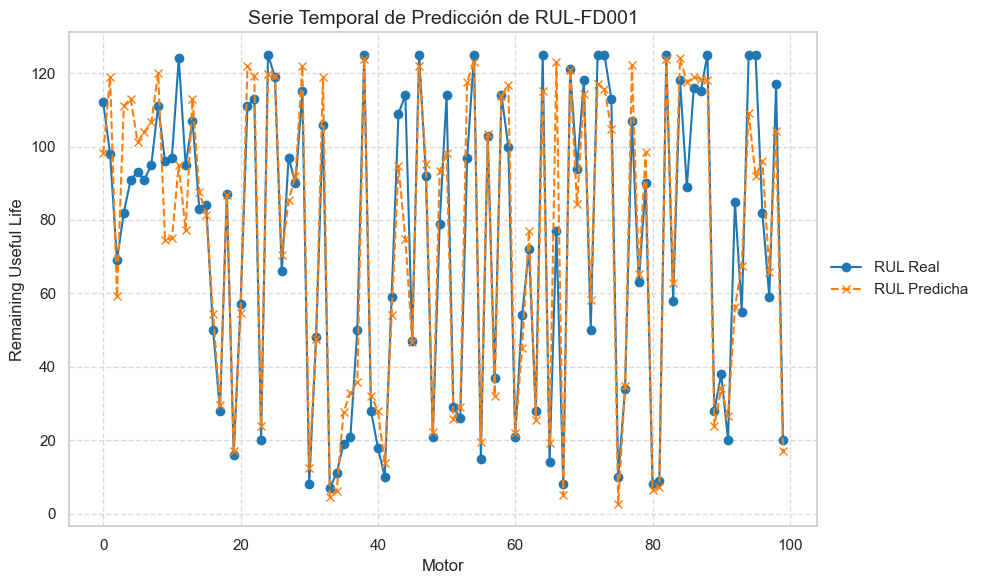

In [44]:
plot_rul_predictions(y_true.clip(upper=125)[:100], predictions[:100], 'FD001')

In [45]:
def plot_rul_comparison(y_true, y_pred, clip_upper=125, buffer=0.05, fixed_limits=True):
    """
    Visualiza comparación entre RUL real y predicho con límites configurables
    
    Parámetros:
        y_true: Valores reales de RUL
        y_pred: Valores predichos de RUL
        clip_upper: Valor máximo para recortar RUL real (300 según tu imagen)
        buffer: Margen porcentual (solo se usa si fixed_limits=False)
        fixed_limits: Si True, usa límites fijos 0-300
    """
    # Convertir y procesar datos
    y_true_f = pd.to_numeric(np.array(y_true).ravel(), errors='coerce').clip(max=clip_upper)
    y_pred_f = np.array(y_pred).ravel().astype(float)
    mask = ~np.isnan(y_true_f)
    y_true_f, y_pred_f = y_true_f[mask], y_pred_f[mask]
    
    # Configurar límites
    if fixed_limits:
        x_min, x_max = -75, 250
        y_min, y_max = -75, 250
    else:
        y_min = min(np.min(y_true_f), np.min(y_pred_f))
        y_max = max(np.max(y_true_f), np.max(y_pred_f))
        range_padding = (y_max - y_min) * buffer
        x_min, x_max = y_min-range_padding, y_max+range_padding
        y_min, y_max = x_min, x_max
    
    # Crear figura
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Scatter plot
    ax.scatter(y_true_f, y_pred_f, alpha=0.7, color='#1f77b4', edgecolor='black', label='Predicciones')
    
    # Línea ideal
    ax.plot([x_min, x_max], [x_min, x_max], 'r--', label='Ideal (y = x)')
    
    # Configurar ejes (usando los límites definidos)
    ax.set(xlabel='RUL Real',
           ylabel='RUL Predicha',
           title='Dispersión: RUL Real vs RUL Predicha',
           xlim=(x_min, x_max),
           ylim=(y_min, y_max))
    
    # Cuadrícula y leyenda
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    plt.tight_layout()
    return fig

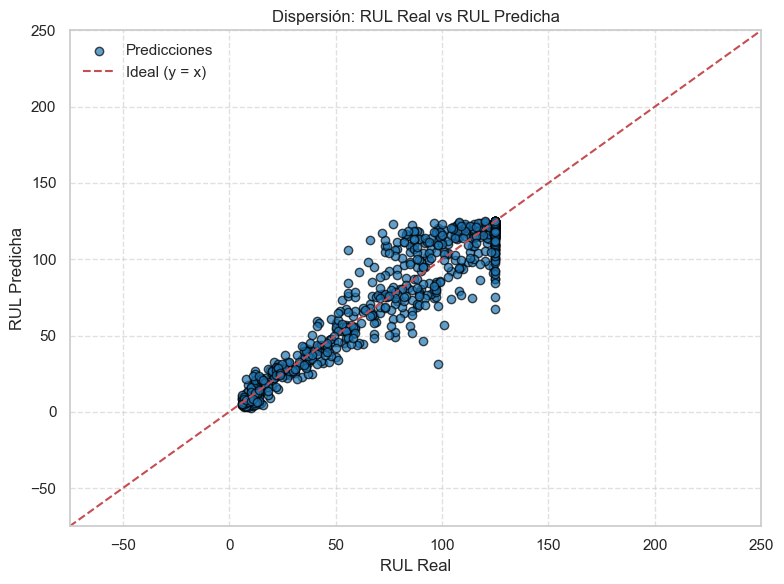

In [46]:
fig = plot_rul_comparison(y_true, predictions, fixed_limits=True)

## **Optimización de Hyperparámetros.**

### **Optuna.**

Optuna es una biblioteca de optimización de hiperparámetros eficiente y automatizada que permite encontrar configuraciones óptimas de modelos de machine learning mediante búsqueda bayesiana. En este proyecto, se utiliza Optuna para ajustar los hiperparámetros de un modelo Transformer enfocado en la predicción de la Remaining Useful Life (RUL) en motores aeronáuticos. Se emplea una base de datos SQLite para almacenar los resultados de los experimentos, lo cual facilita su recuperación y análisis posterior. El estudio, denominado "transformer_rul", se configura para minimizar la función objetivo a lo largo de 100 pruebas, utilizando el muestreador TPE (Tree-structured Parzen Estimator) con una semilla fija para asegurar la reproducibilidad. Al finalizar, se reportan los mejores hiperparámetros encontrados durante el proceso.

Se trabajará con Optuna para la bsuqueda de hyperparámetros, a continuación las siguientes comparativa:

| Característica                 | GridSearchCV                        | RandomizedSearchCV                    | Optuna                                 |
|-------------------------------|-------------------------------------|----------------------------------------|-----------------------------------------|
| Estrategia                    | Búsqueda exhaustiva                 | Búsqueda aleatoria                    | Optimización secuencial adaptativa      |
| Eficiencia                    | Baja (costosa con muchos parámetros)| Media                                 | Alta                                    |
| Velocidad                     | Lenta                               | Más rápida que GridSearch             | Más rápida e inteligente                |
| Exploración inteligente       | ❌                                  | ❌                                     | ✅ (usa historial para decidir)         |
| Early Stopping (parada temprana)| ❌                               | ❌                                     | ✅                                      |
| Soporte para espacio continuo | ❌ (solo valores discretos)         | ✅                                     | ✅                                      |
| Visualización y análisis      | ❌ (requiere herramientas externas) | ❌                                     | ✅ (dashboard, gráficos, etc.)          |
| Fácil de usar                 | ✅ (scikit-learn)                   | ✅ (scikit-learn)                      | ⚠️ (requiere más configuración)         |
| Recomendado para              | Búsquedas pequeñas                  | Búsquedas medianas                    | Búsquedas grandes y costosas            |


#### **DATOS.**

In [47]:
# Número de épocas sin mejora antes de detener el entrenamiento anticipadamente
EPOCHS = 20# gran número de épocas para el entrenamiento anticipado
patience = 4

In [48]:
# Define los espacios de búsqueda
space = {
    'd_model': [64, 128],  #[32, 64, 128],#
    'nhead': [2, 4], # [2, 4, 8],
    'num_layers': [2, 3],# [2, 3, 4]
    'dim_feedforward': [128, 256], # [64, 128, 256],
    'lr': [1e-4, 1e-3], # [1e-5, 1e-4, 1e-3],
    'batch_size': [32, 64], # 'batch_size': [16, 32, 64, 128],
    'window_size': [20, 30], # [10, 20, 30, 40, 50],        
}

# Generar todas las combinaciones
keys = list(space.keys())
values = list(space.values())

combinations = list(product(*values))

print(f"Total de combinaciones posibles: {len(combinations)}")

Total de combinaciones posibles: 128


### **Proceso.**

In [51]:
best_global_rmse = float('inf')
seen_configs = set() 
feature_cols = sensor_cols + list(X_train_encoded.columns[X_train_encoded.columns.str.startswith('operating_condition_id_')])	
target_col = 'RUL'

In [52]:
# Definir la función objetivo de Optuna para la optimización de hiperparámetros.
from copy import deepcopy

def objective(trial):
    try:

        start_time = time.time()

        # Por el momento no es necesario evitar combinaciones inválidas (e.g., d_model no divisible por nhead)
        print('Inicio \n')
        # Seleccionar hiperparámetros de manera aleatoria para cada prueba
        d_model = trial.suggest_categorical('d_model', [64, 128])  # Dimensión del modelo (embedding)
        nhead = trial.suggest_categorical('nhead', [2, 4]) # Número de cabezas de atención
        num_layers = trial.suggest_categorical('num_layers', [3, 4]) # Número de capas de encoder en el Transformer
        dim_feedforward = trial.suggest_categorical('dim_feedforward', [128, 256])# Dimensión del feedforward
        lr = trial.suggest_categorical('lr', [1e-4, 0.001]) # Tasa de aprendizaje
        batch_size = trial.suggest_categorical('batch_size', [32, 64]) # Tamaño del lote
        window_size = trial.suggest_categorical('window_size', [20, 30]) # Tamaño de la ventana

        # Agrupamos los hiperparámetros como una tupla para comparar
        params = (d_model, nhead, num_layers, dim_feedforward, lr, batch_size, window_size)

        if params in seen_configs:
            print(f"Proceso finalizado: {trial.number} combinación de hiperparámetros repetida." )
            print(f'd_model:{d_model}, nhead:{nhead}, num_layers:{num_layers}, dim_feedforward:{dim_feedforward}, lr:{lr}, batch_size:{batch_size}, window_size:{window_size}')

            sys.stdout.flush()  # Forzar impresión inmediata
    
            # Guardar atributos personalizados para ese trial
            trial.set_user_attr("combinación_repetida", True)
            trial.set_user_attr("params", str(params))

            raise optuna.exceptions.TrialPruned() #
        seen_configs.add(params)

        # Generar las secuencias y dividir los datos en entrenamiento y validación
        print('Generando secuencias ... \n')
        X, y, op_ids = create_sequences_with_condition(X_train_encoded, window_size, sensor_cols, target_col)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        op_ids = torch.tensor(op_ids, dtype=torch.long)
 
        

        #set_seed(SEED) 
        # Divide en entrenamiento y validación (80% / 20%)
        X_train, X_val, y_train, y_val, op_train, op_val = train_test_split(
                            X, y, op_ids, test_size=0.2, random_state=SEED
                                                )

        train_dataset = CMAPSSDataset(X_train, y_train, op_train)
        val_dataset = CMAPSSDataset(X_val, y_val, op_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Crear modelo y optimizador
        set_seed(SEED)  # Asegurar reproducibilidad
        model = TransformerRUL(X.shape[2], num_op_conditions=len(X_train_encoded["operating_condition_id"].unique()),
                               d_model=d_model,nhead=nhead,num_layers=num_layers,dim_feedforward=dim_feedforward).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        print('Entrenando el modelo ... \n')
        train_losses = []
        val_losses = []
        print(f"Trial {trial.number} - Hyperparameters: {trial.params}")

        # configuración Early Stopping 
        best_val_rmse = float('inf')
        patience_counter = 0  # Contador de épocas sin mejora

        for epoch in range(EPOCHS):
            model.train()
            epoch_loss = 0
            for seqs, targets, op_ids in train_loader:
                seqs, targets, op_ids = seqs.to(device), targets.to(device), op_ids.to(device)
                optimizer.zero_grad()
                outputs = model(seqs, op_ids)  # <- PASA EL operating_condition_id
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # VALIDACIÓN
            model.eval()
            val_preds = []
            val_true = []
            val_loss = 0
            with torch.no_grad():
                for seqs, targets, op_ids in val_loader:
                    seqs, targets, op_ids = seqs.to(device), targets.to(device), op_ids.to(device)
                    outputs = model(seqs, op_ids)  # <- PASA EL operating_condition_id
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    val_preds.extend(outputs.cpu().numpy())
                    val_true.extend(targets.cpu().numpy())
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            val_rmse = np.sqrt(mean_squared_error(val_true, val_preds))
            val_rmse = float(val_rmse)
            print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val RMSE: {val_rmse:.4f}")
        
            # --- Lógica de Early Stopping --- 
    # en una segunda etapa del codigo pasamos de mse a rmse para el proceso de early stopping
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                patience_counter = 0  # Reiniciar contador
                print(f"¡Nuevo mejor modelo! Val Loss: {avg_val_loss:.4f}, Val RMSE: {val_rmse:.4f}")
                checkpoint = {
                    'epoch': epoch,
                    'model_state': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'best_val_rmse': best_val_rmse,
                    }
                torch.save(checkpoint, f'best_model_mtransformer_emb_{trial.number}.pt')#  garantizar reproducibilidad
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly Stopping @ Epoch {epoch+1} (Mejor Val Loss: {best_val_rmse:.4f})")
                    break  # Detener entrenamiento    

        ## setear triales
        trial.set_user_attr("train_loss", float(train_losses[-1]))
        trial.set_user_attr("val_loss", float(val_losses[-1]))
        trial.set_user_attr("best_val_rmse", float(best_val_rmse))
        trial.set_user_attr("early_stopping_epoch", epoch + 1)
        end_time = time.time()
        duration = end_time - start_time
        trial.set_user_attr("duration_seconds", duration)

        # time
        duration_str = time.strftime("%H:%M:%S", time.gmtime(duration))
        trial.set_user_attr("duration_formatted", duration_str)

        print(f'Tiempo de duración del Trial{trial.number}: {duration_str}')
        print('Fin ... \n')
        return float(val_rmse)
    except Exception as e:
        print(f"Trial {trial.number} eliminado por error: {e}")
        raise optuna.exceptions.TrialPruned()

In [53]:
# Ejecutar la optimización con Optuna
set_seed(SEED)
storage = optuna.storages.RDBStorage(url="sqlite:///optuna_study_transformer_emb_att_rul.db")

study = optuna.create_study(study_name="transformer_emb_att_rul", direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED), storage=storage,
    load_if_exists=True) # Minimizar la pérdida y establecer la semilla para reproducibilidad
study.optimize(objective, n_trials=20)  # Realizar 20 pruebas

[I 2025-05-26 10:06:15,104] Using an existing study with name 'transformer_emb_att_rul' instead of creating a new one.


Inicio 

Generando secuencias ... 

Entrenando el modelo ... 

Trial 21 - Hyperparameters: {'d_model': 128, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 256, 'lr': 0.0001, 'batch_size': 32, 'window_size': 20}
Epoch 1/20, Train Loss: 1362.8558, Val Loss: 256.5656, Val RMSE: 16.0180
¡Nuevo mejor modelo! Val Loss: 256.5656, Val RMSE: 16.0180
Epoch 2/20, Train Loss: 252.2582, Val Loss: 238.3176, Val RMSE: 15.4383
¡Nuevo mejor modelo! Val Loss: 238.3176, Val RMSE: 15.4383
Epoch 3/20, Train Loss: 230.8875, Val Loss: 220.8323, Val RMSE: 14.8609
¡Nuevo mejor modelo! Val Loss: 220.8323, Val RMSE: 14.8609
Epoch 4/20, Train Loss: 214.3994, Val Loss: 210.6784, Val RMSE: 14.5146
¡Nuevo mejor modelo! Val Loss: 210.6784, Val RMSE: 14.5146
Epoch 5/20, Train Loss: 204.8368, Val Loss: 204.2033, Val RMSE: 14.2898
¡Nuevo mejor modelo! Val Loss: 204.2033, Val RMSE: 14.2898
Epoch 6/20, Train Loss: 199.9992, Val Loss: 204.9314, Val RMSE: 14.3153
Epoch 7/20, Train Loss: 197.5216, Val Loss: 202.7385, Val RM

[I 2025-05-26 11:48:01,810] Trial 21 finished with value: 13.901159286499023 and parameters: {'d_model': 128, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 256, 'lr': 0.0001, 'batch_size': 32, 'window_size': 20}. Best is trial 6 with value: 11.843299865722656.


Inicio 

Generando secuencias ... 

Entrenando el modelo ... 

Trial 22 - Hyperparameters: {'d_model': 64, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 128, 'lr': 0.0001, 'batch_size': 32, 'window_size': 30}
Epoch 1/20, Train Loss: 1915.7604, Val Loss: 221.6331, Val RMSE: 14.8900
¡Nuevo mejor modelo! Val Loss: 221.6331, Val RMSE: 14.8900
Epoch 2/20, Train Loss: 222.9037, Val Loss: 207.0421, Val RMSE: 14.3914
¡Nuevo mejor modelo! Val Loss: 207.0421, Val RMSE: 14.3914
Epoch 3/20, Train Loss: 210.1706, Val Loss: 197.6236, Val RMSE: 14.0602
¡Nuevo mejor modelo! Val Loss: 197.6236, Val RMSE: 14.0602
Epoch 4/20, Train Loss: 199.9786, Val Loss: 186.4601, Val RMSE: 13.6570
¡Nuevo mejor modelo! Val Loss: 186.4601, Val RMSE: 13.6570
Epoch 5/20, Train Loss: 188.3756, Val Loss: 174.8473, Val RMSE: 13.2249
¡Nuevo mejor modelo! Val Loss: 174.8473, Val RMSE: 13.2249
Epoch 6/20, Train Loss: 178.6025, Val Loss: 168.2713, Val RMSE: 12.9733
¡Nuevo mejor modelo! Val Loss: 168.2713, Val RMSE: 12.9733
Ep

[I 2025-05-26 13:34:25,894] Trial 22 finished with value: 12.199426651000977 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 128, 'lr': 0.0001, 'batch_size': 32, 'window_size': 30}. Best is trial 6 with value: 11.843299865722656.


Tiempo de duración del Trial22: 01:46:23
Fin ... 

Inicio 

Generando secuencias ... 

Entrenando el modelo ... 

Trial 23 - Hyperparameters: {'d_model': 64, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 128, 'lr': 0.0001, 'batch_size': 32, 'window_size': 30}
Epoch 1/20, Train Loss: 1972.6682, Val Loss: 363.1487, Val RMSE: 19.0600
¡Nuevo mejor modelo! Val Loss: 363.1487, Val RMSE: 19.0600
Epoch 2/20, Train Loss: 292.3513, Val Loss: 213.3310, Val RMSE: 14.6082
¡Nuevo mejor modelo! Val Loss: 213.3310, Val RMSE: 14.6082
Epoch 3/20, Train Loss: 225.3007, Val Loss: 193.5771, Val RMSE: 13.9166
¡Nuevo mejor modelo! Val Loss: 193.5771, Val RMSE: 13.9166
Epoch 4/20, Train Loss: 205.2923, Val Loss: 182.7088, Val RMSE: 13.5204
¡Nuevo mejor modelo! Val Loss: 182.7088, Val RMSE: 13.5204
Epoch 5/20, Train Loss: 194.8364, Val Loss: 175.3688, Val RMSE: 13.2461
¡Nuevo mejor modelo! Val Loss: 175.3688, Val RMSE: 13.2461
Epoch 6/20, Train Loss: 186.3445, Val Loss: 172.2589, Val RMSE: 13.1282
¡Nuevo mej

[I 2025-05-26 14:55:39,689] Trial 23 finished with value: 11.843299865722656 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 128, 'lr': 0.0001, 'batch_size': 32, 'window_size': 30}. Best is trial 6 with value: 11.843299865722656.


Tiempo de duración del Trial23: 01:21:13
Fin ... 

Inicio 

Proceso finalizado: 24 combinación de hiperparámetros repetida.
d_model:64, nhead:2, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30
Trial 24 eliminado por error: 


[I 2025-05-26 14:55:39,976] Trial 24 pruned. 


Inicio 

Proceso finalizado: 25 combinación de hiperparámetros repetida.
d_model:64, nhead:2, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 14:55:40,111] Trial 25 pruned. 


Trial 25 eliminado por error: 
Inicio 

Proceso finalizado: 26 combinación de hiperparámetros repetida.
d_model:64, nhead:2, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 14:55:40,240] Trial 26 pruned. 


Trial 26 eliminado por error: 
Inicio 

Proceso finalizado: 27 combinación de hiperparámetros repetida.
d_model:64, nhead:2, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 14:55:40,372] Trial 27 pruned. 


Trial 27 eliminado por error: 
Inicio 

Proceso finalizado: 28 combinación de hiperparámetros repetida.
d_model:64, nhead:2, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 14:55:40,596] Trial 28 pruned. 


Trial 28 eliminado por error: 
Inicio 

Generando secuencias ... 

Entrenando el modelo ... 

Trial 29 - Hyperparameters: {'d_model': 128, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 256, 'lr': 0.001, 'batch_size': 64, 'window_size': 20}
Epoch 1/20, Train Loss: 548.2813, Val Loss: 222.3012, Val RMSE: 14.9095
¡Nuevo mejor modelo! Val Loss: 222.3012, Val RMSE: 14.9095
Epoch 2/20, Train Loss: 224.7579, Val Loss: 214.1756, Val RMSE: 14.6344
¡Nuevo mejor modelo! Val Loss: 214.1756, Val RMSE: 14.6344
Epoch 3/20, Train Loss: 214.2507, Val Loss: 213.6411, Val RMSE: 14.6158
¡Nuevo mejor modelo! Val Loss: 213.6411, Val RMSE: 14.6158
Epoch 4/20, Train Loss: 208.7359, Val Loss: 204.3103, Val RMSE: 14.2933
¡Nuevo mejor modelo! Val Loss: 204.3103, Val RMSE: 14.2933
Epoch 5/20, Train Loss: 205.5147, Val Loss: 200.2087, Val RMSE: 14.1490
¡Nuevo mejor modelo! Val Loss: 200.2087, Val RMSE: 14.1490
Epoch 6/20, Train Loss: 217.7333, Val Loss: 199.5413, Val RMSE: 14.1253
¡Nuevo mejor modelo! Val Loss: 

[I 2025-05-26 16:18:23,796] Trial 29 finished with value: 13.85757064819336 and parameters: {'d_model': 128, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 256, 'lr': 0.001, 'batch_size': 64, 'window_size': 20}. Best is trial 6 with value: 11.843299865722656.


Tiempo de duración del Trial29: 01:22:43
Fin ... 

Inicio 

Proceso finalizado: 30 combinación de hiperparámetros repetida.
d_model:64, nhead:2, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 16:18:24,047] Trial 30 pruned. 


Trial 30 eliminado por error: 
Inicio 

Generando secuencias ... 

Entrenando el modelo ... 

Trial 31 - Hyperparameters: {'d_model': 128, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 128, 'lr': 0.0001, 'batch_size': 32, 'window_size': 30}
Epoch 1/20, Train Loss: 1434.5108, Val Loss: 229.5115, Val RMSE: 15.1531
¡Nuevo mejor modelo! Val Loss: 229.5115, Val RMSE: 15.1531
Epoch 2/20, Train Loss: 217.7938, Val Loss: 203.3586, Val RMSE: 14.2636
¡Nuevo mejor modelo! Val Loss: 203.3586, Val RMSE: 14.2636
Epoch 3/20, Train Loss: 198.7807, Val Loss: 188.1721, Val RMSE: 13.7211
¡Nuevo mejor modelo! Val Loss: 188.1721, Val RMSE: 13.7211
Epoch 4/20, Train Loss: 185.4257, Val Loss: 178.1312, Val RMSE: 13.3501
¡Nuevo mejor modelo! Val Loss: 178.1312, Val RMSE: 13.3501
Epoch 5/20, Train Loss: 175.6861, Val Loss: 169.0945, Val RMSE: 13.0061
¡Nuevo mejor modelo! Val Loss: 169.0945, Val RMSE: 13.0061
Epoch 6/20, Train Loss: 167.4588, Val Loss: 163.6067, Val RMSE: 12.7924
¡Nuevo mejor modelo! Val Loss

[I 2025-05-26 18:04:26,814] Trial 31 finished with value: 11.911965370178223 and parameters: {'d_model': 128, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 128, 'lr': 0.0001, 'batch_size': 32, 'window_size': 30}. Best is trial 6 with value: 11.843299865722656.


Tiempo de duración del Trial31: 01:46:02
Fin ... 

Inicio 

Generando secuencias ... 

Entrenando el modelo ... 

Trial 32 - Hyperparameters: {'d_model': 128, 'nhead': 2, 'num_layers': 3, 'dim_feedforward': 256, 'lr': 0.001, 'batch_size': 64, 'window_size': 20}
Epoch 1/20, Train Loss: 530.9195, Val Loss: 223.1216, Val RMSE: 14.9365
¡Nuevo mejor modelo! Val Loss: 223.1216, Val RMSE: 14.9365
Epoch 2/20, Train Loss: 223.4100, Val Loss: 212.1022, Val RMSE: 14.5630
¡Nuevo mejor modelo! Val Loss: 212.1022, Val RMSE: 14.5630
Epoch 3/20, Train Loss: 214.0983, Val Loss: 206.4712, Val RMSE: 14.3682
¡Nuevo mejor modelo! Val Loss: 206.4712, Val RMSE: 14.3682
Epoch 4/20, Train Loss: 209.8017, Val Loss: 202.6023, Val RMSE: 14.2332
¡Nuevo mejor modelo! Val Loss: 202.6023, Val RMSE: 14.2332
Epoch 5/20, Train Loss: 206.0471, Val Loss: 207.3954, Val RMSE: 14.4008
Epoch 6/20, Train Loss: 204.3676, Val Loss: 208.6224, Val RMSE: 14.4434
Epoch 7/20, Train Loss: 202.5945, Val Loss: 197.7284, Val RMSE: 14.061

[I 2025-05-26 18:34:58,328] Trial 32 finished with value: 14.192878723144531 and parameters: {'d_model': 128, 'nhead': 2, 'num_layers': 3, 'dim_feedforward': 256, 'lr': 0.001, 'batch_size': 64, 'window_size': 20}. Best is trial 6 with value: 11.843299865722656.


Tiempo de duración del Trial32: 00:30:31
Fin ... 

Inicio 

Proceso finalizado: 33 combinación de hiperparámetros repetida.
d_model:64, nhead:2, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 18:34:58,560] Trial 33 pruned. 


Trial 33 eliminado por error: 
Inicio 

Proceso finalizado: 34 combinación de hiperparámetros repetida.
d_model:128, nhead:4, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 18:34:58,663] Trial 34 pruned. 


Trial 34 eliminado por error: 
Inicio 

Proceso finalizado: 35 combinación de hiperparámetros repetida.
d_model:128, nhead:4, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 18:34:58,809] Trial 35 pruned. 


Trial 35 eliminado por error: 
Inicio 

Proceso finalizado: 36 combinación de hiperparámetros repetida.
d_model:128, nhead:4, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 18:34:58,941] Trial 36 pruned. 


Trial 36 eliminado por error: 
Inicio 

Generando secuencias ... 

Entrenando el modelo ... 

Trial 37 - Hyperparameters: {'d_model': 128, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 128, 'lr': 0.001, 'batch_size': 64, 'window_size': 30}
Epoch 1/20, Train Loss: 521.1309, Val Loss: 208.2323, Val RMSE: 14.4275
¡Nuevo mejor modelo! Val Loss: 208.2323, Val RMSE: 14.4275
Epoch 2/20, Train Loss: 179.7558, Val Loss: 188.4678, Val RMSE: 13.7254
¡Nuevo mejor modelo! Val Loss: 188.4678, Val RMSE: 13.7254
Epoch 3/20, Train Loss: 171.9156, Val Loss: 183.9562, Val RMSE: 13.5603
¡Nuevo mejor modelo! Val Loss: 183.9562, Val RMSE: 13.5603
Epoch 4/20, Train Loss: 168.1597, Val Loss: 169.3646, Val RMSE: 13.0107
¡Nuevo mejor modelo! Val Loss: 169.3646, Val RMSE: 13.0107
Epoch 5/20, Train Loss: 166.1159, Val Loss: 164.7180, Val RMSE: 12.8311
¡Nuevo mejor modelo! Val Loss: 164.7180, Val RMSE: 12.8311
Epoch 6/20, Train Loss: 163.0059, Val Loss: 159.7267, Val RMSE: 12.6350
¡Nuevo mejor modelo! Val Loss: 

[I 2025-05-26 19:48:40,763] Trial 37 finished with value: 12.155584335327148 and parameters: {'d_model': 128, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 128, 'lr': 0.001, 'batch_size': 64, 'window_size': 30}. Best is trial 6 with value: 11.843299865722656.


Tiempo de duración del Trial37: 01:13:41
Fin ... 

Inicio 

Proceso finalizado: 38 combinación de hiperparámetros repetida.
d_model:128, nhead:4, num_layers:4, dim_feedforward:128, lr:0.0001, batch_size:32, window_size:30


[I 2025-05-26 19:48:41,014] Trial 38 pruned. 


Trial 38 eliminado por error: 
Inicio 

Proceso finalizado: 39 combinación de hiperparámetros repetida.
d_model:128, nhead:4, num_layers:3, dim_feedforward:128, lr:0.001, batch_size:64, window_size:30


[I 2025-05-26 19:48:41,155] Trial 39 pruned. 


Trial 39 eliminado por error: 
Inicio 

Generando secuencias ... 

Entrenando el modelo ... 

Trial 40 - Hyperparameters: {'d_model': 128, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 128, 'lr': 0.0001, 'batch_size': 32, 'window_size': 20}
Epoch 1/20, Train Loss: 1439.7643, Val Loss: 259.9729, Val RMSE: 16.1240
¡Nuevo mejor modelo! Val Loss: 259.9729, Val RMSE: 16.1240
Epoch 2/20, Train Loss: 256.1393, Val Loss: 243.7086, Val RMSE: 15.6116
¡Nuevo mejor modelo! Val Loss: 243.7086, Val RMSE: 15.6116
Epoch 3/20, Train Loss: 237.9468, Val Loss: 225.1728, Val RMSE: 15.0064
¡Nuevo mejor modelo! Val Loss: 225.1728, Val RMSE: 15.0064
Epoch 4/20, Train Loss: 221.6669, Val Loss: 215.8286, Val RMSE: 14.6914
¡Nuevo mejor modelo! Val Loss: 215.8286, Val RMSE: 14.6914
Epoch 5/20, Train Loss: 210.4928, Val Loss: 207.5913, Val RMSE: 14.4081
¡Nuevo mejor modelo! Val Loss: 207.5913, Val RMSE: 14.4081
Epoch 6/20, Train Loss: 202.5829, Val Loss: 201.9494, Val RMSE: 14.2109
¡Nuevo mejor modelo! Val Loss

[I 2025-05-26 21:13:02,195] Trial 40 finished with value: 13.830952644348145 and parameters: {'d_model': 128, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 128, 'lr': 0.0001, 'batch_size': 32, 'window_size': 20}. Best is trial 6 with value: 11.843299865722656.


Tiempo de duración del Trial40: 01:24:20
Fin ... 



In [54]:
# Imprimir los mejores parámetros
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'d_model': 64, 'nhead': 2, 'num_layers': 4, 'dim_feedforward': 128, 'lr': 0.0001, 'batch_size': 32, 'window_size': 30}


### **Análisis del estudio.**

Optuna desarrrolla sus pruebas basada en un conjunto triales a los que llama estudios.

#### **Mejor Trial.**

In [71]:
# Conectarse a la base de datos SQLite
storage = optuna.storages.RDBStorage(url="sqlite:///optuna_study_transformer_emb_att_rul.db")

# Cargar la study persistente
study = optuna.load_study(study_name="transformer_emb_att_rul", storage=storage)

print("Best trial:")
print(f"  Value (loss): {study.best_value}")
print(f"  Params: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
print(f"  Number of trials: {len(study.trials)}")
print(f"  Best trial number: {study.best_trial.number}")

Best trial:
  Value (loss): 11.843299865722656
  Params: 
    d_model: 64
    nhead: 2
    num_layers: 4
    dim_feedforward: 128
    lr: 0.0001
    batch_size: 32
    window_size: 30
  Number of trials: 41
  Best trial number: 6


#### **Visualizaciones.**

In [ ]:
# Visualización en un local host
# pip install optuna-dashboard
#import optuna_dashboard
#optuna_dashboard.run_server("sqlite:///optuna_study_rul_tranformer.db")

Bottle v0.13.3 server starting up (using WSGIRefServer())...
Listening on http://localhost:8080/
Hit Ctrl-C to quit.

127.0.0.1 - - [20/May/2025 00:28:24] "GET / HTTP/1.1" 302 0
127.0.0.1 - - [20/May/2025 00:28:24] "GET /dashboard HTTP/1.1" 200 4145
127.0.0.1 - - [20/May/2025 00:28:25] "GET /static/bundle.js HTTP/1.1" 200 4140872
127.0.0.1 - - [20/May/2025 00:28:29] "GET /api/studies HTTP/1.1" 200 143
127.0.0.1 - - [20/May/2025 00:28:30] "GET /favicon.ico HTTP/1.1" 200 7670
c:\Users\equipo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna_dashboard\_importance.py:96: ExperimentalWarning: PedAnovaImportanceEvaluator is experimental (supported from v3.6.0). The interface can change in the future.
  study, target=target, evaluator=PedAnovaImportanceEvaluator()
c:\Users\equipo\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\importance\_ped_anova\evaluator.py:150: UserWarning: PedAnovaImportanceEvaluator computes the importances of params to achieve low `targ

##### Historial de optimización

In [36]:
#optuna.visualization.plot_optimization_history(study)
# Visualizar el historial de optimización
optuna.visualization.plot_optimization_history(study).show()

##### **Importancia de cada Hiperparámetro.**

In [37]:
# Visualizar la importancia de cada hiperparámetro
optuna.visualization.plot_param_importances(study).show()

##### **Distribuciones por Hyperparámetros.**

Permite ver la distribución de la función objetivo en relación con cada hiperparámetro. Ayuda a identificar valores críticos o zonas de interés.


In [ ]:
optuna.visualization.plot_slice(study).show()

## **Modelo final** ##

Ejecuto y entreno el modelo con los mejores hiperparámetros.

Best trial:
  Value (loss): 11.843299865722656
  Params: 
    d_model: 64
    nhead: 2
    num_layers: 4
    dim_feedforward: 128
    lr: 0.0001
    batch_size: 32
    window_size: 30
  Number of trials: 41
  Best trial number: 6

### **Entrenamiento** ###

In [59]:
EPOCHS = 30
LR=0.0001
BATCH_SIZE=32
WINDOW_SIZE=30

In [ ]:
# Generar las secuencias y dividir los datos en entrenamiento y validación
print('Generando secuencias ... \n')
X, y, op_ids = create_sequences_with_condition(X_train_encoded, WINDOW_SIZE, sensor_cols, target_col)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
op_ids = torch.tensor(op_ids, dtype=torch.long)


In [63]:
# Divide en entrenamiento y validación (80% / 20%)
X_train, X_val, y_train, y_val, op_train, op_val = train_test_split(
                            X, y, op_ids, test_size=0.2, random_state=SEED
                                                )

train_dataset = CMAPSSDataset(X_train, y_train, op_train)
val_dataset = CMAPSSDataset(X_val, y_val, op_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [65]:
# Crear modelo y optimizador
set_seed(SEED)  # Asegurar reproducibilidad
model = TransformerRUL(X.shape[2], num_op_conditions=len(X_train_encoded["operating_condition_id"].unique()),
                               d_model=64,nhead=2,num_layers=4,dim_feedforward=128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print('Entrenando el modelo ... \n')
train_losses = []
val_losses = []

# configuración Early Stopping 
best_val_rmse = float('inf')
patience_counter = 0  # Contador de épocas sin mejora

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for seqs, targets, op_ids in train_loader:
        seqs, targets, op_ids = seqs.to(device), targets.to(device), op_ids.to(device)
        optimizer.zero_grad()
        outputs = model(seqs, op_ids)  # <- PASA EL operating_condition_id
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # VALIDACIÓN
    model.eval()
    val_preds = []
    val_true = []
    val_loss = 0
    with torch.no_grad():
        for seqs, targets, op_ids in val_loader:
            seqs, targets, op_ids = seqs.to(device), targets.to(device), op_ids.to(device)
            outputs = model(seqs, op_ids)  # <- PASA EL operating_condition_id
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_preds.extend(outputs.cpu().numpy())
            val_true.extend(targets.cpu().numpy())
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_rmse = np.sqrt(mean_squared_error(val_true, val_preds))
        val_rmse = float(val_rmse)
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val RMSE: {val_rmse:.4f}")
        
         # --- Lógica de Early Stopping --- 
    # en una segunda etapa del codigo pasamos de mse a rmse para el proceso de early stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            patience_counter = 0  # Reiniciar contador
            print(f"¡Nuevo mejor modelo! Val Loss: {avg_val_loss:.4f}, Val RMSE: {val_rmse:.4f}")
            checkpoint = {
                    'epoch': epoch,
                    'model_state': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'best_val_rmse': best_val_rmse,
                    }
            torch.save(checkpoint, f'best_model_mtransformer_emb_final.pt')# 
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly Stopping @ Epoch {epoch+1} (Mejor Val Loss: {best_val_rmse:.4f})")
                break  # Detener entrenamiento   


Entrenando el modelo ... 

Epoch 1/30, Train Loss: 1972.6682, Val Loss: 363.1487, Val RMSE: 19.0600
¡Nuevo mejor modelo! Val Loss: 363.1487, Val RMSE: 19.0600
Epoch 2/30, Train Loss: 292.3513, Val Loss: 213.3310, Val RMSE: 14.6082
¡Nuevo mejor modelo! Val Loss: 213.3310, Val RMSE: 14.6082
Epoch 3/30, Train Loss: 225.3007, Val Loss: 193.5771, Val RMSE: 13.9166
¡Nuevo mejor modelo! Val Loss: 193.5771, Val RMSE: 13.9166
Epoch 4/30, Train Loss: 205.2923, Val Loss: 182.7088, Val RMSE: 13.5204
¡Nuevo mejor modelo! Val Loss: 182.7088, Val RMSE: 13.5204
Epoch 5/30, Train Loss: 194.8364, Val Loss: 175.3688, Val RMSE: 13.2461
¡Nuevo mejor modelo! Val Loss: 175.3688, Val RMSE: 13.2461
Epoch 6/30, Train Loss: 186.3445, Val Loss: 172.2589, Val RMSE: 13.1282
¡Nuevo mejor modelo! Val Loss: 172.2589, Val RMSE: 13.1282
Epoch 7/30, Train Loss: 180.9760, Val Loss: 168.3075, Val RMSE: 12.9763
¡Nuevo mejor modelo! Val Loss: 168.3075, Val RMSE: 12.9763
Epoch 8/30, Train Loss: 176.2414, Val Loss: 166.0304, V

### **Curva de Aprendizaje** ###

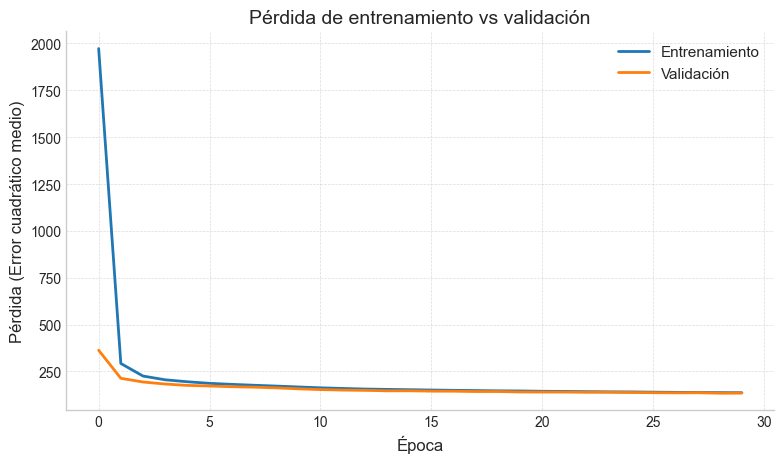

In [66]:
# Estilo limpio y legible
plt.style.use("seaborn-v0_8-whitegrid")  

fig, ax = plt.subplots(figsize=(8, 4.8))  # buena relación de aspecto 5:3

ax.plot(train_losses, label="Entrenamiento", color="#1f77b4", linewidth=2)
ax.plot(val_losses, label="Validación", color="#ff7f0e", linewidth=2)

# Etiquetas claras y específicas
ax.set_xlabel("Época", fontsize=12)
ax.set_ylabel("Pérdida (Error cuadrático medio)", fontsize=12)
ax.set_title("Pérdida de entrenamiento vs validación", fontsize=14)

# Mejorar legibilidad
ax.legend(frameon=False, fontsize=11)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="both", labelsize=10)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

### **Prueba** ###

In [67]:
X_test_list = []
op_id_list = []

# Para cada unidad, extraemos la última secuencia completa de tamaño WINDOW_SIZE
for unit in X_test_encoded['unit_nr'].unique():
    unit_df = X_test_encoded[X_test_encoded['unit_nr'] == unit].sort_values('time_cycles')
    
    if len(unit_df) >= WINDOW_SIZE:
        seq_df = unit_df.iloc[-WINDOW_SIZE:]
    else:
        pad = pd.DataFrame(0, index=range(WINDOW_SIZE - len(unit_df)), columns=unit_df.columns)
        seq_df = pd.concat([pad, unit_df], ignore_index=True).iloc[-WINDOW_SIZE:]

    # Extraer secuencia de sensores
    seq = seq_df[feature_cols].values
    X_test_list.append(seq)

    # Extraer el último operating_condition_id como representación de la secuencia
    op_id = seq_df['operating_condition_id'].values[-1]
    op_id_list.append(op_id)

# Convertir a tensores
X_test = np.array(X_test_list)
op_ids_test = np.array(op_id_list)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
op_test_tensor = torch.tensor(op_ids_test, dtype=torch.long).to(device)

In [92]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor, op_test_tensor)
    attention_weights = model.sensor_attention.att_weights

print(attention_weights.shape)  # Debería ser (batch_size, 1, feature_dim)
print(predictions.shape)  # Debería ser (batch_size, 1, feature_dim)

torch.Size([707, 1, 21])
torch.Size([707])


### **Resultado.** ###

In [69]:
# Calcular la métrica de evaluación (RMSE o R²) en el conjunto de validación
metrics = compute_metrics(y_true, predictions)
print(f"RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.2f}")

RMSE: 12.91, R²: 0.91


In [ ]:
# Guardar el estado del modelo.
#torch.save(model.state_dict(), 'transformer_model_first_embeddings.pth')

In [ ]:
#best_model_mtransformer_emb_final = torch.load('transformer_model_first_embeddings.pth', map_location=device, weights_only=True)
#model.load_state_dict(best_model_mtransformer_emb_final)

### **FD001.** ###

In [148]:
X_test_list = []
op_id_list = []

# Para cada unidad, extraemos la última secuencia completa de tamaño WINDOW_SIZE
for unit in X_test_encoded['unit_nr'].unique()[0:100]:
    unit_df = X_test_encoded[X_test_encoded['unit_nr'] == unit].sort_values('time_cycles')
    
    if len(unit_df) >= WINDOW_SIZE:
        seq_df = unit_df.iloc[-WINDOW_SIZE:]
    else:
        pad = pd.DataFrame(0, index=range(WINDOW_SIZE - len(unit_df)), columns=unit_df.columns)
        seq_df = pd.concat([pad, unit_df], ignore_index=True).iloc[-WINDOW_SIZE:]

    # Extraer secuencia de sensores
    seq = seq_df[feature_cols].values
    X_test_list.append(seq)

    # Extraer el último operating_condition_id como representación de la secuencia
    op_id = seq_df['operating_condition_id'].values[-1]
    op_id_list.append(op_id)

# Convertir a tensores
X_test = np.array(X_test_list)
op_ids_test = np.array(op_id_list)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
op_test_tensor = torch.tensor(op_ids_test, dtype=torch.long).to(device)

In [149]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor, op_test_tensor)

In [150]:
metrics = compute_metrics(y_true[:100], predictions)
print(f"RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.2f}")

RMSE: 12.92, R²: 0.90


### **FD002.** ###

In [166]:
X_test_list = []
op_id_list = []

# Para cada unidad, extraemos la última secuencia completa de tamaño WINDOW_SIZE
for unit in X_test_encoded['unit_nr'].unique()[101:360]:
    unit_df = X_test_encoded[X_test_encoded['unit_nr'] == unit].sort_values('time_cycles')
    
    if len(unit_df) >= WINDOW_SIZE:
        seq_df = unit_df.iloc[-WINDOW_SIZE:]
    else:
        pad = pd.DataFrame(0, index=range(WINDOW_SIZE - len(unit_df)), columns=unit_df.columns)
        seq_df = pd.concat([pad, unit_df], ignore_index=True).iloc[-WINDOW_SIZE:]

    # Extraer secuencia de sensores
    seq = seq_df[feature_cols].values
    X_test_list.append(seq)

    # Extraer el último operating_condition_id como representación de la secuencia
    op_id = seq_df['operating_condition_id'].values[-1]
    op_id_list.append(op_id)

# Convertir a tensores
X_test = np.array(X_test_list)
op_ids_test = np.array(op_id_list)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
op_test_tensor = torch.tensor(op_ids_test, dtype=torch.long).to(device)

In [167]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor, op_test_tensor)

In [169]:
metrics = compute_metrics(y_true[101:360], predictions)
print(f"RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.2f}")

RMSE: 12.53, R²: 0.91


### **FD003** ###

In [144]:
print(len(X_test_encoded['unit_nr'].unique()[361:461]))

100


In [170]:
X_test_list = []
op_id_list = []

# Para cada unidad, extraemos la última secuencia completa de tamaño WINDOW_SIZE
for unit in X_test_encoded['unit_nr'].unique()[361:461]:
    unit_df = X_test_encoded[X_test_encoded['unit_nr'] == unit].sort_values('time_cycles')
    
    if len(unit_df) >= WINDOW_SIZE:
        seq_df = unit_df.iloc[-WINDOW_SIZE:]
    else:
        pad = pd.DataFrame(0, index=range(WINDOW_SIZE - len(unit_df)), columns=unit_df.columns)
        seq_df = pd.concat([pad, unit_df], ignore_index=True).iloc[-WINDOW_SIZE:]

    # Extraer secuencia de sensores
    seq = seq_df[feature_cols].values
    X_test_list.append(seq)

    # Extraer el último operating_condition_id como representación de la secuencia
    op_id = seq_df['operating_condition_id'].values[-1]
    op_id_list.append(op_id)

# Convertir a tensores
X_test = np.array(X_test_list)
op_ids_test = np.array(op_id_list)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
op_test_tensor = torch.tensor(op_ids_test, dtype=torch.long).to(device)

In [171]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor, op_test_tensor)


In [172]:
metrics = compute_metrics(y_true[361:461], predictions)
print(f"RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.2f}")

RMSE: 11.65, R²: 0.91


### **FD004** ###

In [177]:
X_test_list = []
op_id_list = []

# Para cada unidad, extraemos la última secuencia completa de tamaño WINDOW_SIZE
for unit in X_test_encoded['unit_nr'].unique()[462:707]:
    unit_df = X_test_encoded[X_test_encoded['unit_nr'] == unit].sort_values('time_cycles')
    
    if len(unit_df) >= WINDOW_SIZE:
        seq_df = unit_df.iloc[-WINDOW_SIZE:]
    else:
        pad = pd.DataFrame(0, index=range(WINDOW_SIZE - len(unit_df)), columns=unit_df.columns)
        seq_df = pd.concat([pad, unit_df], ignore_index=True).iloc[-WINDOW_SIZE:]

    # Extraer secuencia de sensores
    seq = seq_df[feature_cols].values
    X_test_list.append(seq)

    # Extraer el último operating_condition_id como representación de la secuencia
    op_id = seq_df['operating_condition_id'].values[-1]
    op_id_list.append(op_id)

# Convertir a tensores
X_test = np.array(X_test_list)
op_ids_test = np.array(op_id_list)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
op_test_tensor = torch.tensor(op_ids_test, dtype=torch.long).to(device)

In [179]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor, op_test_tensor)

In [180]:
metrics = compute_metrics(y_true[462:707], predictions)
print(f"RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.2f}")

RMSE: 13.80, R²: 0.90


### **Atención sensorial.** ###

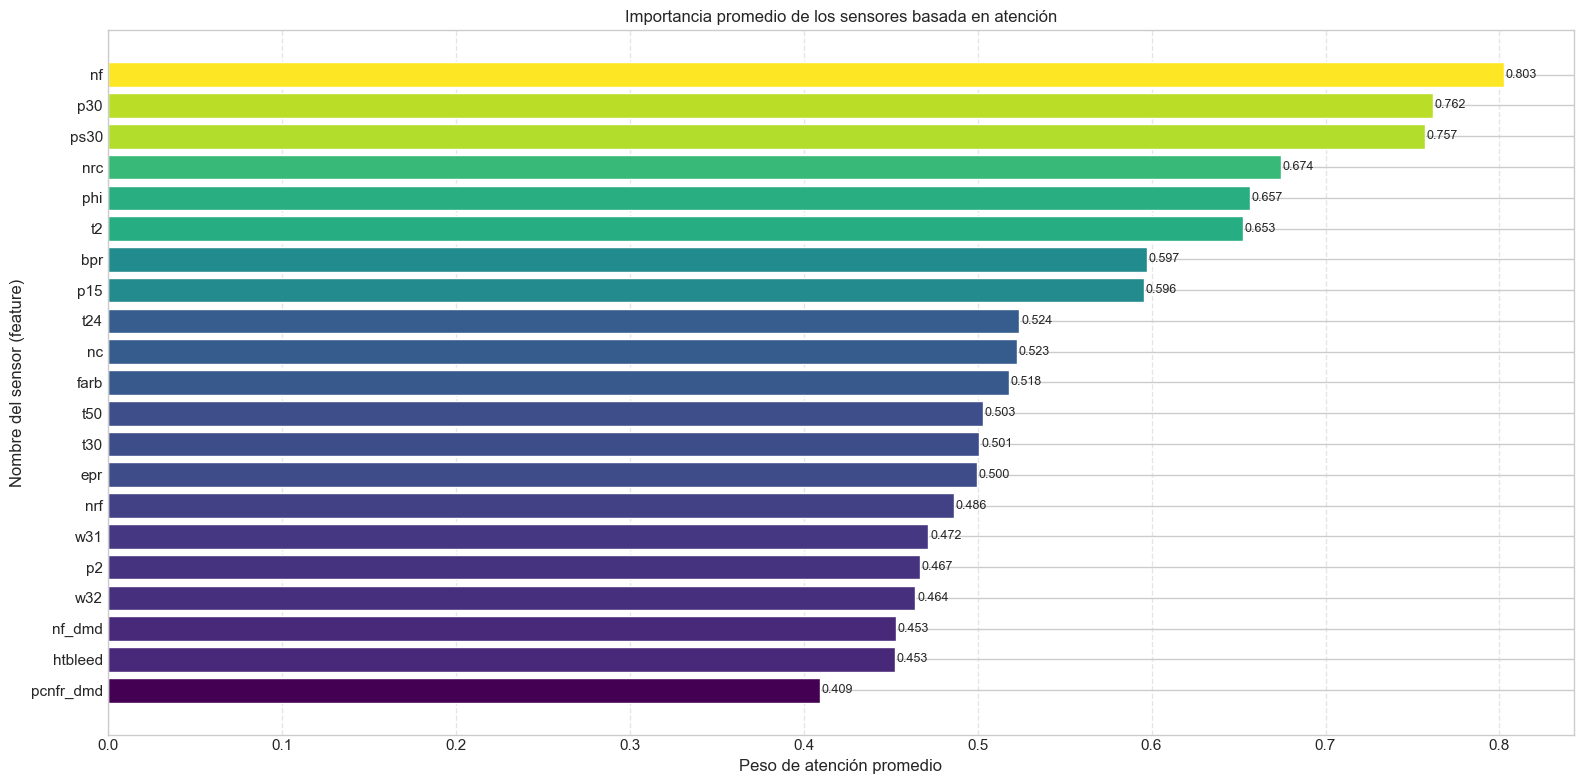

In [75]:
# Convertir y calcular pesos de atención promedio
att_weights_np = attention_weights.squeeze(1).cpu().numpy()  # (batch_size, feature_dim)
mean_weights = att_weights_np.mean(axis=0)

# Crear DataFrame y ordenar
attention_df = pd.DataFrame({
    'feature': feature_cols,
    'attention_weight': mean_weights
}).sort_values(by='attention_weight', ascending=True)

# Normalizar para aplicar viridis
norm = plt.Normalize(attention_df['attention_weight'].min(), attention_df['attention_weight'].max())
colors = plt.cm.viridis(norm(attention_df['attention_weight'].values))

# Gráfico horizontal
plt.figure(figsize=(16, 8))
bars = plt.barh(
    attention_df['feature'],
    attention_df['attention_weight'],
    color=colors
)

# Añadir texto con los valores
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001,             # un poco a la derecha del final de la barra
             bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}",            # formato con 3 decimales
             va='center', ha='left', fontsize=9)

# Personalización
plt.xlabel("Peso de atención promedio")
plt.ylabel("Nombre del sensor (feature)")
plt.title("Importancia promedio de los sensores basada en atención")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Visualizaciones.** ###

In [86]:
def plot_rul_comparison(y_true, y_pred, clip_upper=125, buffer=0.05, fixed_limits=True):
    """
    Visualiza comparación entre RUL real y predicho con límites configurables
    
    Parámetros:
        y_true: Valores reales de RUL
        y_pred: Valores predichos de RUL
        clip_upper: Valor máximo para recortar RUL real (300 según tu imagen)
        buffer: Margen porcentual (solo se usa si fixed_limits=False)
        fixed_limits: Si True, usa límites fijos 0-300
    """
    # Convertir y procesar datos
    y_true_f = pd.to_numeric(np.array(y_true).ravel(), errors='coerce').clip(max=clip_upper)
    y_pred_f = np.array(y_pred).ravel().astype(float)
    mask = ~np.isnan(y_true_f)
    y_true_f, y_pred_f = y_true_f[mask], y_pred_f[mask]
    
    # Configurar límites
    if fixed_limits:
        x_min, x_max = -75, 250
        y_min, y_max = -75, 250
    else:
        y_min = min(np.min(y_true_f), np.min(y_pred_f))
        y_max = max(np.max(y_true_f), np.max(y_pred_f))
        range_padding = (y_max - y_min) * buffer
        x_min, x_max = y_min-range_padding, y_max+range_padding
        y_min, y_max = x_min, x_max
    
    # Crear figura
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Scatter plot
    ax.scatter(y_true_f, y_pred_f, alpha=0.7, color='#1f77b4', edgecolor='black', label='Predicciones')
    
    # Línea ideal
    ax.plot([x_min, x_max], [x_min, x_max], 'r--', label='Ideal (y = x)')
    
    # Configurar ejes (usando los límites definidos)
    ax.set(xlabel='RUL Real',
           ylabel='RUL Predicha',
           title='Dispersión: RUL Real vs RUL Predicha',
           xlim=(x_min, x_max),
           ylim=(y_min, y_max))
    
    # Cuadrícula y leyenda
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    plt.tight_layout()
    return fig

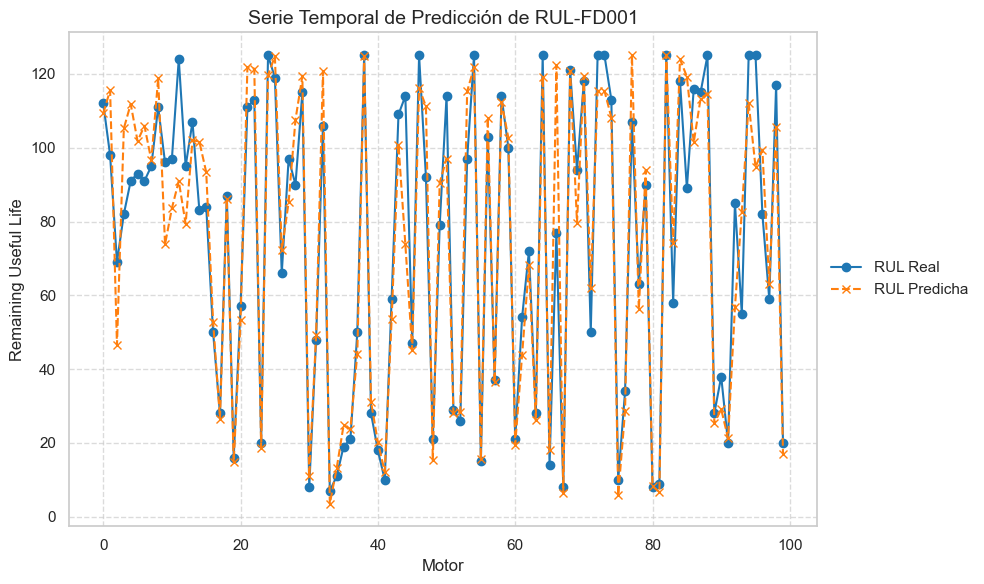

In [87]:
plot_rul_predictions(y_true.clip(upper=125)[:100], predictions[:100],'FD001')  # Serie temporal

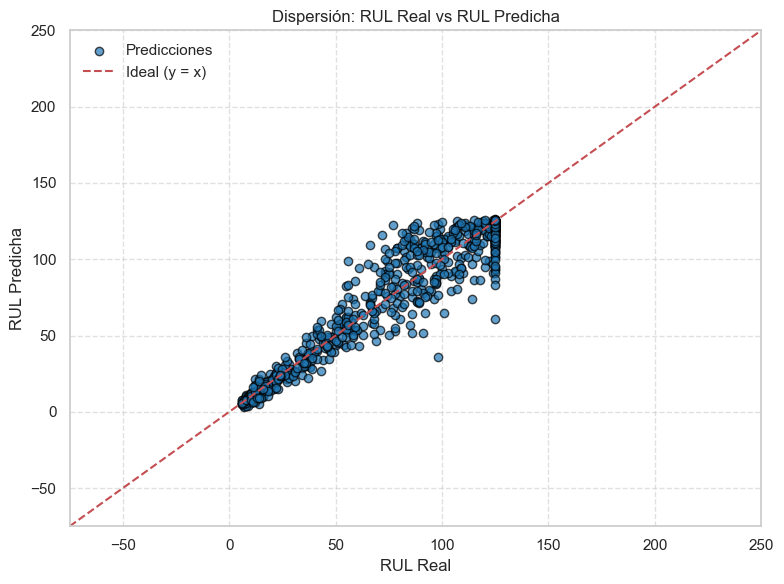

In [88]:
fig = plot_rul_comparison(y_true, predictions, fixed_limits=True)